## Predicting Retweets of @realDonaldTrump Twitter account. 

## Abstract
Twitter is one of the most popular platforms for expressing opinions, thoughts and updates, but it is also used to influence people and is a "tactic" widely used in election campaigns. President Donald Trump's Twitter account is very popular, his tweet frequency is relatively high, and his tweets are liked and retweeted hundreds of thousands of times.

This notebook implements a regression model to predict the number of retweets of a particular tweet from @realdonaldtrump. Additionally the meaning of features is evaluated and compared.

The result of this notebook is, besides the prediction model, a set of important characteristics for a high number of retweets. These can be used to increase the retweet rate of candidates for future election campaigns. Our model can be used to decide on which parts to focus on when tweeting (length, specific hashtags, time of day, etc.) in order to maximize the number of retweets and gain popularity or even become viral.

## Data Selection

For the task of this notebook the Tweets and the Retweet counts of the @realdonaldtrump Twitter account are needed. This notebooks uses the data from http://trumptwitterarchive.com/archive. The data spans from Donald J. Trumps inauguration on January 20, 2017 until March 30, 2020. 

***TO DO: look for better name for the dataset, optional direct download from online source***

In [175]:
#import data from http://trumptwitterarchive.com/archive
import pandas as pd

twitterdata = pd.read_json("data.json")

## Data Exploration

Initial exploration of the dataset.  

In [176]:
#dimension of dataset
dimension_twitterdata = twitterdata.shape
print("The dataset has " + str(dimension_twitterdata[0]) + " records and " +
      str(dimension_twitterdata[1]) + " variables." )

The dataset has 13427 records and 5 variables.


In [177]:
#show the first 10 records of the dataset
print(twitterdata.head(10))

               source                                               text  \
0  Twitter for iPhone  White House news conference at 5:00 P.M. Easte...   
1  Twitter for iPhone                            https://t.co/2hKJkP5Z6N   
2  Twitter for iPhone  On #NationalDoctorsDay, we recognize the remar...   
3  Twitter for iPhone                            https://t.co/nzWJ8ViwbZ   
4  Twitter for iPhone  Nancy Pelosi and the Democrats delayed the Wor...   
5  Twitter for iPhone  Thank you Dr. Hahn &amp; the FDA for your fast...   
6  Twitter for iPhone  Will be interviewed on @foxandfriends at 7:55 ...   
7  Twitter for iPhone                            https://t.co/YzhyVR1N6d   
8  Twitter for iPhone                            https://t.co/MtEehGY9cp   
9  Twitter for iPhone  Will be starting The White House news conferen...   

                 created_at  retweet_count               id_str  
0 2020-03-30 20:50:35+00:00          14441  1244728753617620992  
1 2020-03-30 17:46:15+00:00    

In [178]:
#show variables and variables type
print(twitterdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13427 entries, 0 to 13426
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   source         13427 non-null  object             
 1   text           13427 non-null  object             
 2   created_at     13427 non-null  datetime64[ns, UTC]
 3   retweet_count  13427 non-null  int64              
 4   id_str         13427 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 524.6+ KB
None


The variables in the dataset are source, text, created_at, retweet_count, id_str.

Explanation of the variables. 
* **source** is the kind of device used for the tweet.
* **text** is content of the tweet.
* **created_at** is the timestamp of the tweet in UTC.
* **retweet_count** is number of retweets of the tweet.
* **id_str** is an unique identifier of the tweet.

### Missing data
It can already be seen, that there is no missing data.

### Duplicates

In [179]:
#check for duplicates
dublicated_entries = twitterdata.duplicated(keep = False)
print("There are " + str(dublicated_entries.sum()) + " duplicated entries.")

There are 0 duplicated entries.


In [181]:
#check for duplicate texts
dublicated_text = twitterdata.loc[:, ["text"]].duplicated(keep = False)
print("There are " + str(dublicated_text.sum()) + " duplicated text of tweets.")

There are 243 duplicated text of tweets.


In [182]:
#show tweets with duplicated text.
print(twitterdata[dublicated_text].sort_values(by='created_at').tail(10))

                 source                                               text  \
604  Twitter for iPhone        ....THE UNITED STATES IS OPEN FOR BUSINESS!   
603  Twitter for iPhone  ....I have seen some of the regulations being ...   
602  Twitter for iPhone  ....product and goods to China and other count...   
601  Twitter for iPhone  “Judge Jackson now has a request for a new tri...   
600  Twitter for iPhone  .....would order a new trial, I’m not so sure ...   
599  Twitter for iPhone  .....existence of these tweets in which you we...   
391  Twitter for iPhone  Australia’s Central Bank cut interest rates an...   
389  Twitter for iPhone  Australia’s Central Bank cut interest rates an...   
137  Twitter for iPhone                            https://t.co/ytgBP3hJv1   
81   Twitter for iPhone                            https://t.co/ytgBP3hJv1   

                   created_at  retweet_count               id_str  
604 2020-02-18 15:29:43+00:00           9968  1229790102949449728  
603 2

There are a few dupplicated text, which will be analyzed further. It can be seen that there are text that are repeated, like "MAKE AMERICA GREAT AGAIN" which are not a problem. But on the other site there are text, which seem like they were deleted and reposted later. It is difficult to check which one them is a real retweet and which of them was deleted. 

***TO DO: Check if we could delete the duplicates.*** 

### Check the target class retweet_count
The target class is the number of retweets of a tweet. This is represented in the data as integer (int64).

In [183]:
#maximum of the retweet value
print("The maximal retweet value is " + str(twitterdata.loc[:,'retweet_count'].max()) + "." )

The maximal retweet value is 369530.


Seems legitimate so far.

In [184]:
#minimum of the retweet value
print("The minimal retweet value is " + str(twitterdata.loc[:,'retweet_count'].min()) + "." )

The minimal retweet value is 0.


Seems like there is an outlier here. One hypothesis is that these are the tweets which are deleted and appear two times in the dataset. It cannot be finally confirmed, since we do not have a label for deleted tweets and not every tweet, which was deleted is tweeted again later. If you go back to the site http://www.trumptwitterarchive.com/archive you can see that every tweet here is not availabe anymore. It was probably posted and shortly after deleted. For example the tweet with the ID 366 has 0 retweets, which is deleted. But Trump posted the exact same tweet one minute after this tweet and it got 8000 retweets: https://twitter.com/realdonaldtrump/status/1235034836705959936.

In [185]:
#other summary statistics
twitterdata.loc[:,'retweet_count'].describe()

count     13427.000000
mean      19149.517986
std       12661.057625
min           0.000000
25%       11898.000000
50%       17132.000000
75%       23767.500000
max      369530.000000
Name: retweet_count, dtype: float64

So far so good it looks like there is an skewed distribution of the values.

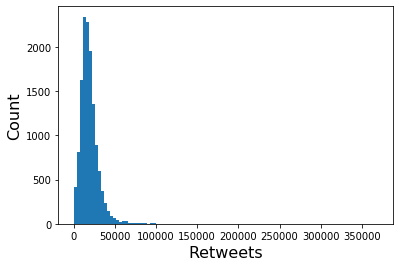

In [186]:
#visualize the retweet frequenzy as histogramm
import matplotlib.pyplot as plt
plt.hist(twitterdata["retweet_count"], bins = 100)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

It can be seen that there is an highly skewed distribution with an long tail. First visual impression shows an one sided truncated normal distribution.

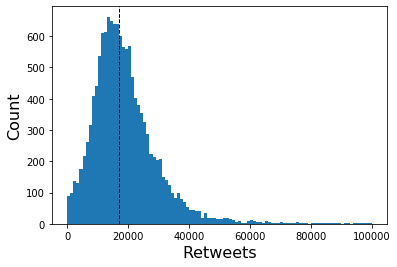

In [187]:
#visualize the retweet frequenzy as histogramm for retweet_count < 100.000
twitterdata_truncated = twitterdata[twitterdata["retweet_count"] < 100000].loc[:, "retweet_count"]
plt.hist(twitterdata_truncated, bins = 100)
plt.axvline(twitterdata_truncated.median(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

Seems like the inital hypothesis is confirmed.

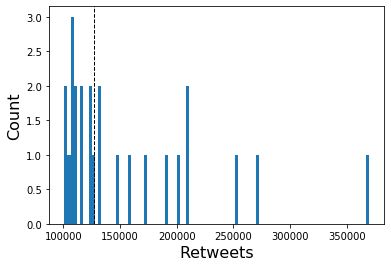

In [188]:
#visualize the retweet frequenzy as histogramm for retweet_count > 100.000
twitterdata_truncated = twitterdata[twitterdata["retweet_count"] > 100000].loc[:, "retweet_count"]
plt.hist(twitterdata_truncated, bins = 100)
plt.axvline(twitterdata_truncated.median(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

There seems nothing wrong here.

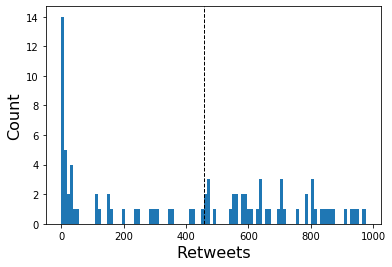

In [189]:
#visualize the retweet frequenzy as histogramm for retweet_count < 1.000
twitterdata_truncated = twitterdata[twitterdata["retweet_count"] < 1000].loc[:, "retweet_count"]
plt.hist(twitterdata_truncated, bins = 100)
plt.axvline(twitterdata_truncated.median(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

Seems like there especially many tweets that have retweet count 0. These will most likely be deleted tweets. The rest could also be deleted tweets.

The first analysis of the retweet count shows that the data is so far so good. The only problem are the potentially deleted tweet, which cannot be analyzed in this first project.

### Check the attribute source
This is represented in the data as strings (object).

In [190]:
#check how many distinct values there are. 
twitterdata_source_unique = twitterdata.loc[:,'source'].unique()
print("There are " + str(twitterdata_source_unique .size) + " distinct values.")

There are 8 distinct values.


In [191]:
#show the different values
print("The different values are:")
print(twitterdata_source_unique)

The different values are:
['Twitter for iPhone' 'Twitter Media Studio' 'Twitter Web App'
 'Twitter Web Client' 'Twitter for iPad' 'Media Studio' 'Twitter Ads'
 'Twitter for Android']


In [192]:
#show the frequency of the different values
twitterdata_source_frequency = twitterdata.groupby(by = "source").count().loc[:,"retweet_count"]
print(twitterdata_source_frequency)

source
Media Studio              155
Twitter Ads                33
Twitter Media Studio      159
Twitter Web App             4
Twitter Web Client         48
Twitter for Android       173
Twitter for iPad           35
Twitter for iPhone      12820
Name: retweet_count, dtype: int64


It can be seen that there are very infrequent classes. It has to be seen, if these should be binned into on class or if they have prediction power. Therefore the next step is to analyze the retweet count based on the source.

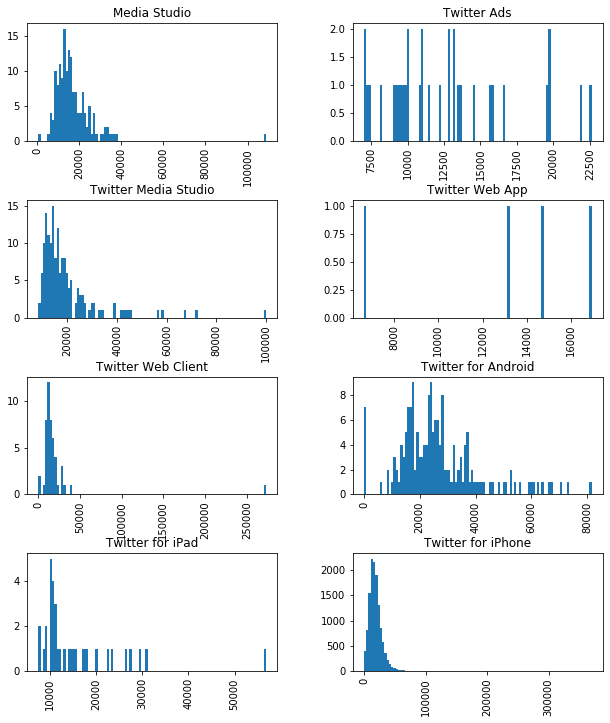

In [193]:
#visualize retweet count based on source
twitterdata_source_hist = twitterdata.hist(column='retweet_count', by='source', bins=100, grid=False, figsize=(10,12), layout=(4,2))

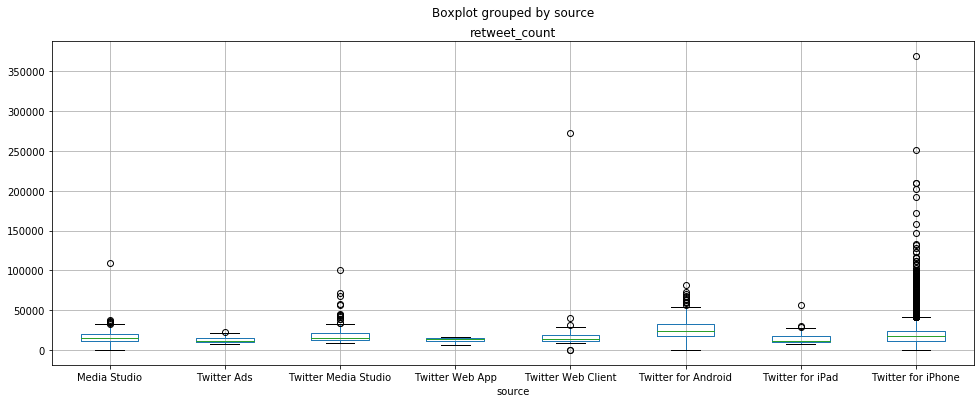

In [194]:
#use boxplots for more clear results
twitterdata_source_boxplot = twitterdata.boxplot(column='retweet_count', by='source', figsize = (16,6))

Seems like there are small differences. Maybe a binning show more significant results. 

In [195]:
#bin values in two categories
twitterdata['source_binary'] = twitterdata["source"] == "Twitter for iPhone"

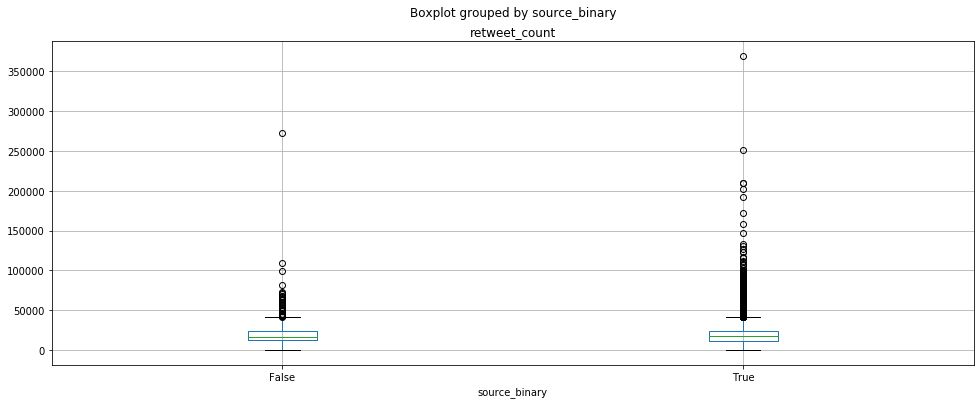

In [196]:
#visualy compare the two categories
twitterdata_source_boxplot = twitterdata.boxplot(column='retweet_count', by='source_binary', figsize = (16,6))

### Check the attribute created_at
This is represented in the data as time (datetime64[ns, UTC]).

In [197]:
#check the basis statistics
twitterdata.loc[:,'created_at'].describe()

count                         13427
unique                        13054
top       2019-05-10 11:22:22+00:00
freq                              4
first     2017-01-20 00:40:51+00:00
last      2020-03-30 20:50:35+00:00
Name: created_at, dtype: object

The data range is the targeted. What is noticable that there non unique values. These are further investigated. 

In [198]:
#show tweets with duplicated dates.
dublicated_text = twitterdata.loc[:, ["created_at"]].duplicated(keep = False)
print("There are " + str(dublicated_text.sum()) + " duplicated dates of tweets.")

There are 710 duplicated dates of tweets.


In [199]:
#check for duplicate texts
print(twitterdata[dublicated_text].sort_values(by='created_at').head(6))

                   source                                               text  \
12815  Twitter for iPhone             Big win in Montana for Republicans! We   
12814  Twitter for iPhone  Just arrived in Italy after having a very succ...   
10645  Twitter for iPhone  Looks like Jerry Brown and California are not ...   
10646  Twitter for iPhone  So many people are seeing the benefits of the ...   
10640  Twitter for iPhone  Today’s Court decision means that Congress mus...   
10641  Twitter for iPhone  ....Congress – House and Senate must quickly p...   

                     created_at  retweet_count              id_str  \
12815 2017-05-28 11:57:20+00:00            428  868798339676086272   
12814 2017-05-28 11:57:20+00:00            416  868798339671830528   
10645 2018-04-17 12:24:36+00:00          15332  986218870506754048   
10646 2018-04-17 12:24:36+00:00          15379  986218871991492608   
10640 2018-04-17 21:34:23+00:00          15804  986357228306354176   
10641 2018-04-17 21

Seems like there is no mistake with the duplicated dates.

Since the data is in UTC +00, it needs to be changed eastern time zone, washington -5.

In [237]:
#change timezone 
twitterdata['created_at_utc'] = twitterdata['created_at']
twitterdata['created_at'] = pd.DatetimeIndex(twitterdata['created_at']).tz_convert('America/New_York')

It is the best guess to change the time to Washington time zone. If he is in other time zones it can not be seen. It also does not necessary have an real impact, since the time difference remains the same. 

In [239]:
#create hour of the day and date as attributes
twitterdata['created_at_hour'] = twitterdata["created_at"].dt.hour
twitterdata['created_at_date'] = twitterdata["created_at"].dt.date

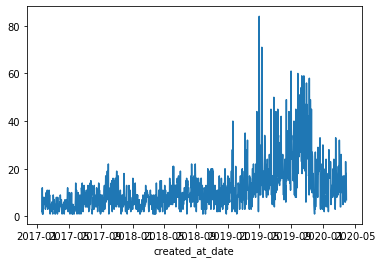

In [240]:
#check if there a times where no data is available 
twitterdata_timeseries = twitterdata.groupby("created_at_date").count().loc[:,"retweet_count"]
twitterdata_timeseries.plot()

Seems like there are no relevant timeperiods without tweets. 

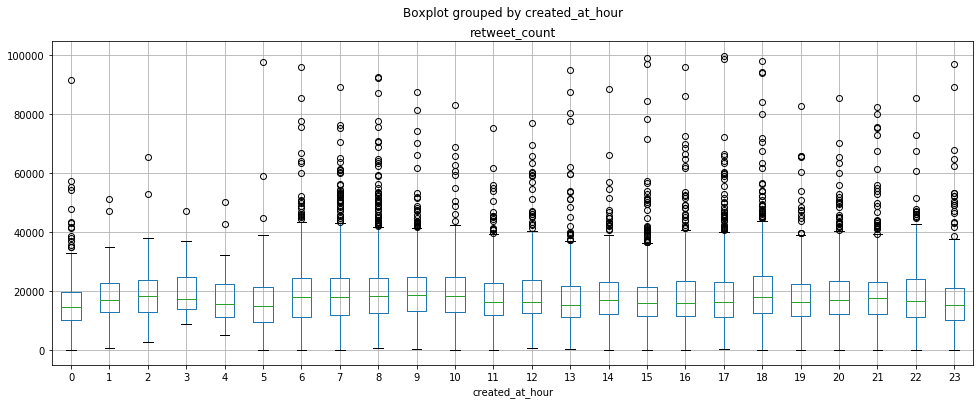

In [277]:
#check if time of the day is relevant feature
twitterdata_source_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='created_at_hour', figsize = (16,6))

There a no immense differences but small changes. Therefore the values are binned into times of day.

In [242]:
#create feature times of day
twitterdata["created_at_daytime"] = pd.cut(twitterdata['created_at_hour'],[0,6,12,18,24], labels = ['Night', 'Morning', 'Afternoon', 'Evening'])

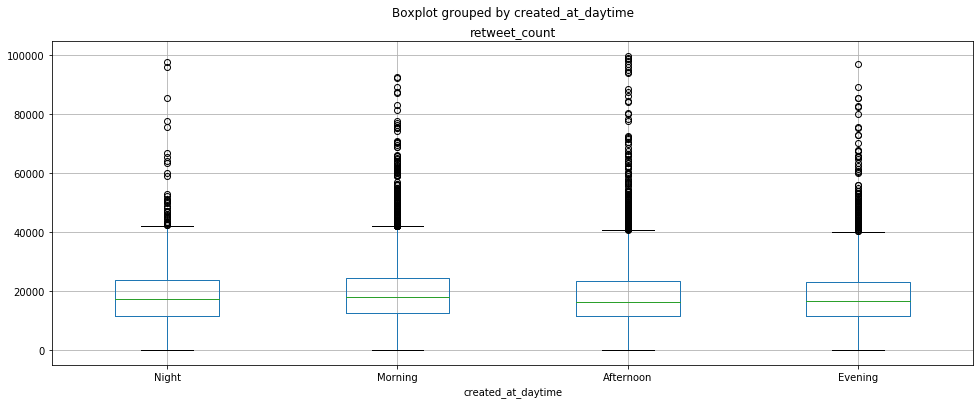

In [278]:
#show impact of feature times of day
twitterdata_source_daytime_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='created_at_daytime', figsize = (16,6))

In [247]:
#create feature day of the week
twitterdata["created_at_weekday"] = twitterdata["created_at"].dt.day_name()

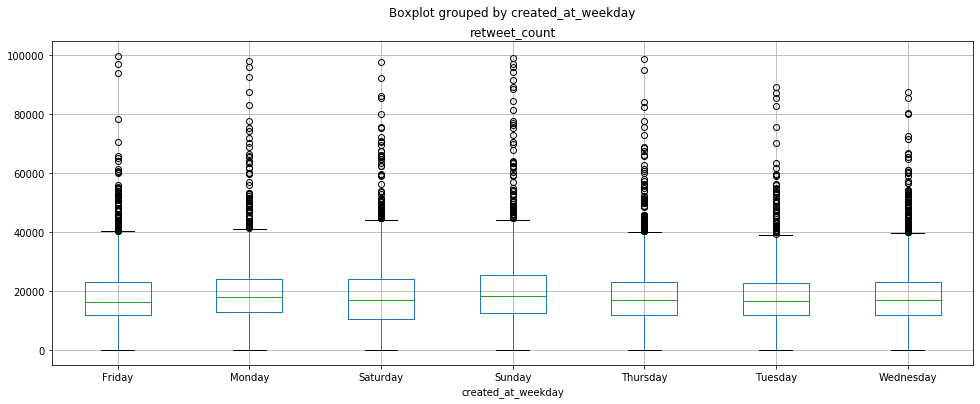

In [279]:
#show impact of feature day of the week
twitterdata_source_weekday_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='created_at_weekday', figsize = (16,6))

In [248]:
#create feature month
twitterdata["created_at_month"] = twitterdata["created_at"].dt.month

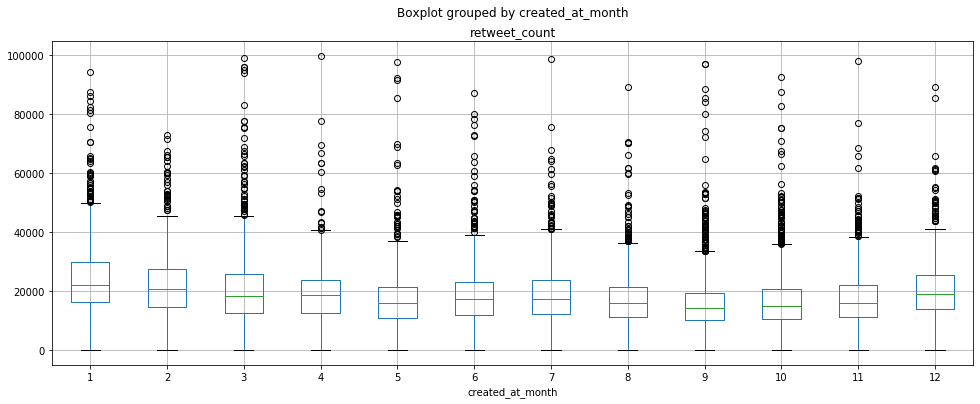

In [280]:
#show impact of feature day of the week
twitterdata_source_month_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='created_at_month', figsize = (16,6))

In [275]:
#create feature age of the tweet in days
from pytz import timezone
date_inaguration = datetime(2017, 1, 20, 0, 0, 1).astimezone(timezone("America/New_York")) #the date Trump was inaugurated
twitterdata['created_at_age_days'] = (twitterdata['created_at'] - date_inaguration).dt.days
twitterdata['created_at_age_months'] = round((twitterdata['created_at'] - date_inaguration).dt.days/30,1)

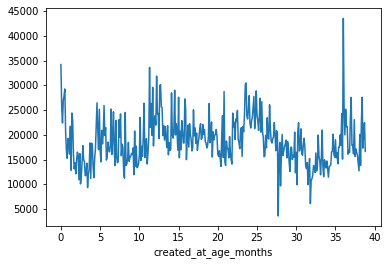

In [276]:
#plot the development of retweets median per month
twitterdata.groupby("created_at_age_months").median()["retweet_count"].plot.line()

Seems like this will be a good feature later.

***TO DO:*** calculate distance to last tweet.

### Check the attribute  id_str  
This is represented in the data as integer (integer64).

In [281]:
#check if this is a unique identifier
if twitterdata["id_str"].nunique() == twitterdata.shape[0]:
    print("This is a unique identifier.")

This is a unique identifier.


Since this variable is a unique identifier it has no relevance for the further training.

### Check the attribute text 
This is represented in the data as strings (object).

In [284]:
#short summary of the attribute
twitterdata['text'].describe()

count                         13427
unique                        13278
top       MAKE AMERICA GREAT AGAIN!
freq                             22
Name: text, dtype: object

The topic of duplicated entries was already discussed before. 

Now it needs to be understood how the strings are decoded and and how
* pictures
* smiley
* videos
* mentions
* urls
* hashtags
are stored

#### Video 
All tweets by Twitter Media Studio or Media Studio contain self hosted videos

In [308]:
#create attribute published video by himself
import numpy as np
twitterdata["video_selfpublished"] = np.logical_or(twitterdata["source"] == "Twitter Media Studio", twitterdata["source"] == "Media Studio")

####  TO DO Check the appearance of photos

####  Hashtags
Extract hastages with regex.

In [329]:
#extract hashtags
import re
#define function to get hashtags
def hashtags(text):
    pattern = re.compile(r"#(\w+)")
    hashtags = pattern.findall(text)
    return hashtags

#apply to dataset
twitterdata['hashtag_content'] =  twitterdata.apply(lambda x: hashtags(x['text']), axis=1)

#if tweet contains hashtag (boolean)
twitterdata['hashtag_included'] =  twitterdata.apply(lambda x: 1 if len(x['hashtag_content']) > 0 else 0, axis=1)

# number of hashtags
twitterdata['hashtag_number'] =  twitterdata.apply(lambda x: len(x['hashtag_content']), axis=1)

In [419]:
#build dictionary to search for most used hastags 
dictionary_hashtags = {} #initialize empy dictionary

#build dictionary
for i in twitterdata.index:
    tweet_text = twitterdata['text'][i]
    tweet_text_tokenized = tweet_text.split()
    
    #check for hashtags
    for word in tweet_text_tokenized:
        if (word[0:1] == '#' and len(word) > 1):
            if word in dictionary_hashtags:
                dictionary_hashtags[word] += 1
            else:
                dictionary_hashtags[word] = 1

#transform to dataframe
dataframe_hashtags = pd.DataFrame(dictionary_hashtags.items(), columns=['Hashtag', 'occurences'])

In [420]:
#analyze dataframe
print("There are " + str(dataframe_hashtags.shape[0]) + " different hashtags.")
dataframe_hashtags.sort_values("occurences", ascending = False).head(n = 10)

There are 712 different hashtags.


,Hashtag,occurences
2,#MAGA,161
12,#KAG2020,58
51,#MAGA🇺🇸,31
520,#USA🇺🇸,23
178,#Dorian,17
21,#KAG,15
111,#1,15
142,#FakeNews,14
162,#UNGA,13
50,#USMCA,12


Since the goal is to have a generalizable model, which extract actionable knowledge Hashtags with occurences of less than 50 (~ 0.5%) will be ignored. This means the only interesting Hashtags are the one with Make America Great Again and Keep America Great. These will be extracted and added as a feature.

In [447]:
#create function for feature generation
def generate_feature(category, value): 
        return twitterdata[category].str.contains(re.compile(value))

In [442]:
#create the two new features
twitterdata.assign(hashtag_maga = generate_feature("text", "#MAGA"))
twitterdata.assign(hashtag_kag = generate_feature("text", "#KAG"))

,source,text,created_at,retweet_count,id_str,source_binary,created_at_et,created_at_hour,created_at_date,created_at_daytime,...,created_at_age_months,video_selfpublished,hashtag_content,hashtag_included,hashtag_number,hashtag_maga,hashtag_kag,mentions_content,mentions_included,mentions_number
0,Twitter for iPhone,White House news conference at 5:00 P.M. Easte...,2020-03-30 16:50:35-04:00,14441,1244728753617620992,True,2020-03-30 16:50:35-04:00,16,2020-03-30,Afternoon,...,38.8,False,[],0,0,False,False,[],0,0
1,Twitter for iPhone,https://t.co/2hKJkP5Z6N,2020-03-30 13:46:15-04:00,15520,1244682364284014592,True,2020-03-30 13:46:15-04:00,13,2020-03-30,Afternoon,...,38.8,False,[],0,0,False,False,[],0,0
2,Twitter for iPhone,"On #NationalDoctorsDay, we recognize the remar...",2020-03-30 13:11:59-04:00,19753,1244673740866191360,True,2020-03-30 13:11:59-04:00,13,2020-03-30,Afternoon,...,38.8,False,[NationalDoctorsDay],1,1,False,False,[],0,0
3,Twitter for iPhone,https://t.co/nzWJ8ViwbZ,2020-03-30 13:05:33-04:00,39114,1244672122414338048,True,2020-03-30 13:05:33-04:00,13,2020-03-30,Afternoon,...,38.8,False,[],0,0,False,False,[],0,0
4,Twitter for iPhone,Nancy Pelosi and the Democrats delayed the Wor...,2020-03-30 07:17:10-04:00,43360,1244584449309892608,True,2020-03-30 07:17:10-04:00,7,2020-03-30,Morning,...,38.8,False,[],0,0,False,False,[],0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13422,Twitter for iPhone,"power from Washington, D.C. and giving it back...",2017-01-20 12:51:58-05:00,18362,822501939267141632,True,2017-01-20 12:51:58-05:00,12,2017-01-20,Morning,...,0.0,False,[InaugurationDay],1,1,False,False,[],0,0
13423,Twitter for iPhone,Today we are not merely transferring power fro...,2017-01-20 12:51:25-05:00,20125,822501803615014912,True,2017-01-20 12:51:25-05:00,12,2017-01-20,Morning,...,0.0,False,[],0,0,False,False,[],0,0
13424,Twitter for Android,It all begins today! I will see you at 11:00 A...,2017-01-20 07:31:53-05:00,70523,822421390125043712,False,2017-01-20 07:31:53-05:00,7,2017-01-20,Morning,...,0.0,False,[],0,0,False,False,[],0,0
13425,Twitter for iPhone,Thank you for a wonderful evening in Washingto...,2017-01-19 23:24:33-05:00,20770,822298747421986816,True,2017-01-19 23:24:33-05:00,23,2017-01-19,Evening,...,0.0,False,[Inauguration],1,1,False,False,[],0,0


#### Mentions
Extract mentions with regex.

In [421]:
#extract mentions
#define function to get mentions
def mentions(text):
    pattern = re.compile(r"@(\w+)")
    mentions = pattern.findall(text)
    return mentions

#apply to dataset
twitterdata['mentions_content'] =  twitterdata.apply(lambda x: mentions(x['text']), axis=1)

#if tweet contains hashtag (boolean)
twitterdata['mentions_included'] =  twitterdata.apply(lambda x: 1 if len(x['mentions_content']) > 0 else 0, axis=1)

# number of hashtags
twitterdata['mentions_number'] =  twitterdata.apply(lambda x: len(x['mentions_content']), axis=1)

In [429]:
#build dictionary to search for most used mentions
dictionary_mentions = {} #initialize empy dictionary

#build dictionary
for i in twitterdata.index:
    tweet_text = twitterdata['text'][i]
    tweet_text_tokenized = tweet_text.split()
    
    #check for hashtags
    for word in tweet_text_tokenized:
        if (word[0:1] == '@' and len(word) > 1):
            if word in dictionary_mentions:
                dictionary_mentions[word] += 1
            else:
                dictionary_mentions[word] = 1

#transform to dataframe
dataframe_mentions = pd.DataFrame(dictionary_mentions.items(), columns=['Mention', 'occurences'])

In [433]:
#analyze dataframe
print("There are " + str(dataframe_mentions.shape[0]) + " different mentions.")
dataframe_mentions.sort_values("occurences", ascending = False).head(n = 15)

There are 1867 different mentions.


,Mention,occurences
23,@FoxNews,254
256,@realDonaldTrump:,232
273,@realDonaldTrump,225
1,@foxandfriends,204
272,@WhiteHouse:,158
347,@GOPChairwoman:,77
16,@WhiteHouse,76
201,@dbongino,64
24,@LouDobbs,58
314,@TomFitton:,57


Since the goal is to have a generalizable model, which extract actionable knowledge menntions with occurences of less than 50 (~ 0.5%) will be ignored. This means the only interesting mentions are: ,@FoxNews, @realDonaldTrump, @foxandfriends, @WhiteHouse, @GOPChairwoman, @dbongino, @LouDobbs, @TomFitton, @seanhannity, @Jim_Jordan. These will be extracted and added as a feature.

In [445]:
dataframe_mentions[dataframe_mentions["occurences"] > 50]["Mention"]

1         @foxandfriends
16           @WhiteHouse
22          @seanhannity
23              @FoxNews
24             @LouDobbs
201            @dbongino
256    @realDonaldTrump:
266         @Jim_Jordan:
272         @WhiteHouse:
273     @realDonaldTrump
314          @TomFitton:
347      @GOPChairwoman:
Name: Mention, dtype: object

In [464]:
#create new features     
twitterdata["mention_foxnews"] = generate_feature("text", "@FoxNews")
twitterdata["mention_realdonaldtrump"] = generate_feature("text", "@realDonaldTrump")
twitterdata["mention_foxandfriends"] = generate_feature("text", "@foxandfriends")
twitterdata["mention_whitehouse"] = generate_feature("text", "@FoxNews")
twitterdata["mention_gopchairwoman"] = generate_feature("text", "@GOPChairwoman")
twitterdata["mention_dbongino"] = generate_feature("text", "@dbongino")
twitterdata["mention_loudobbs"] = generate_feature("text", "@LouDobbs")
twitterdata["mention_tomfi8tton"] = generate_feature("text", "@TomFitton")
twitterdata["mention_seanhannity"] = generate_feature("text", "@seanhannity")
twitterdata["mention_jimjordan"] = generate_feature("text", "@Jim_Jordan")

####  TO DO Check the appearance of smileys

#### Urls
Extract urls.

In [480]:
#extract urls
#define function to get urls
def urls(text):
    pattern = re.compile(r"http\S+")
    urls_content = pattern.findall(text)
    return urls_content

#apply to dataset
twitterdata['urls_content'] =  twitterdata.apply(lambda x: urls(x['text']), axis=1)

#if tweet contains hashtag (boolean)
twitterdata['urls_included'] =  twitterdata.apply(lambda x: 1 if len(x['urls_content']) > 0 else 0, axis=1)

# number of hashtags
twitterdata['urls_number'] =  twitterdata.apply(lambda x: len(x['urls_content']), axis=1)

In [493]:
twitterdata['urls_content'] 

0                               []
1        [https://t.co/2hKJkP5Z6N]
2        [https://t.co/7PRogpEVTP]
3        [https://t.co/nzWJ8ViwbZ]
4                               []
                   ...            
13422                           []
13423                           []
13424                           []
13425    [https://t.co/a6xpFQTHj5]
13426    [https://t.co/OSxa3BamHs]
Name: urls_content, Length: 13427, dtype: object

In [511]:
#build dictionary to search for most used mentions
dictionary_urls = {} #initialize empy dictionary

#build dictionary
for i in twitterdata.index:
    tweet_text = twitterdata['text'][i]
    tweet_text_tokenized = tweet_text.split()
    
    #check for hashtags
    for word in tweet_text_tokenized:
        if (word[0:4] == 'http'):
            if word in dictionary_urls:
                dictionary_urls[word] += 1
            else:
                dictionary_urls[word] = 1

#transform to dataframe
dataframe_urls = pd.DataFrame(dictionary_urls.items(), columns=['Mention', 'occurences'])

In [514]:
#analyze dataframe
print("There are " + str(dataframe_urls.shape[0]) + " different urls.")
dataframe_urls.sort_values("occurences", ascending = False).head(n = 5)

There are 4023 different urls.


,Mention,occurences
2486,https://t.co/0pWiwCHGbh,17
1326,https://t.…,10
840,https://…,9
2532,https://t.co/0pWiwCq4MH,8
979,https://t.c…,8


Seems like there is no real frequent urls. Therefore they will not be used further.

In [528]:
#create feature length of tweets
twitterdata["text_lenght"] = twitterdata["text"].apply(len)

## Text feature creation
From the text there are many possibilities to create features. Now the text will be tokenized and preprocessed. Since the goal is a explaining algorithm the number of features will be hold small in favor for explainability.

#### Preprocess text

In [529]:
# remove punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        if punctuation != '!': # leave exclamation mark
            text = text.replace(punctuation, '')
    return text

twitterdata['text'] = twitterdata.apply(lambda x: remove_punctuations(x['text']), axis=1)

In [531]:
#remove numbers 
def remove_numbers(text):
    return re.sub('[0-9]+', '', text)

twitterdata['text'] = twitterdata.apply(lambda x: remove_numbers(x['text']), axis=1)

In [532]:
#remove special characters
def remove_special(text):
    for char in ['€','�','‡','†','‰','™','•']:
        text = text.replace(char, '')
    return text

twitterdata['text'] = twitterdata.apply(lambda x: remove_special(x['text']), axis=1)

In [533]:
#if word starts with uppercase --> lowercase, if all chars are uppercase --> do nothing
def lower_case(text):
    to_lowercase = lambda text: " ".join(word if (word.isupper() == True & len(word) >= 1) else word.lower()
            for word in text.split())
    lowercase = to_lowercase(text)   
    return lowercase

twitterdata['text'] = twitterdata.apply(lambda x: lower_case(x['text']), axis=1)

#### Tokenize text

In [543]:
#simple count vektorizing
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(twitterdata['text'])
document_term = pd.DataFrame(count_matrix.toarray(), columns = vectorizer.get_feature_names())

In [544]:
document_term.head()

,aaa,aap,ab,abaco,abandon,abandoned,abbas,abbott,abc,abcnews,...,바라보며,받고,북측을,브리핑을,오울렛,정상의,초소는,초소에서,한국전쟁,한미
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [551]:
# TF-IDF vector extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

tknzr = TweetTokenizer()

def tokenize(text):
    tokens = tknzr.tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
word_features = vectorizer.fit_transform(twitterdata['text'])

vectorizer.get_feature_names()
word_features = pd.DataFrame(word_features.todense(), columns = vectorizer.get_feature_names())
word_features.shape

/Users/jakob/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_wo

(13427, 15675)

**Remove stopwords**

**Stemming**

In [555]:
twitterdata = twitterdata.rename(columns={"text": "transformed_text"})

In [554]:
twitterdata = pd.concat([twitterdata, word_features], ignore_index=False, sort =False, axis=1)

In [557]:
b = []
for i in range(0,13427):
    b.append((len(twitterdata["transformed_text"][i] )))
    
twitterdata['tweet_length'] = b

KeyError: 0

In [ ]:
nlp = spacy.load("en_core_web_sm")

#text = "Nancy Pelosi"

l=[]
# Process the text
for text in data['transformed_text']:
    doc = nlp(text)
    p=[]
# Iterate over the entities
    for ent in doc.ents:
        p.append(ent.label_)
        #print(ent.text, ent.label_)
    if 'PERSON' in p:
        l.append(1)
    else: l.append(0)
        
data['person'] = l

In [ ]:
data["day_of_week"] = data["day_of_week"].astype('category')
data["time_of_day"] = data["time_of_day"].astype('category')
data["day_of_week_encoded"] = data["day_of_week"].cat.codes
data["time_of_day_encoded"] = data["time_of_day"].cat.codes
data["time_diff"] = (data["created_at"][1] - data["created_at"]).dt.days
data.head()

In [ ]:
drop_coloumns = ['hashtags', 'created_at', 'id_str', 'source', 'transformed_text', 'day_of_week', 'time_of_day']
selected_coloumns = data.drop(drop_coloumns, axis=1)
selected_coloumns.head()

In [ ]:
y = selected_coloumns.loc[:, ["retweet_count"]]
X = selected_coloumns.drop(["retweet_count"], axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train = X_train.values
X_test = X_test.values

'''
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
'''

In [ ]:
estimator = LinearRegression()
time_diff = X_train[:, -1].reshape(-1, 1)
baseline_scores = cross_val_score(estimator, time_diff, \
                         y_train["retweet_count"], cv=20, scoring='neg_mean_squared_error')

baseline_score = -np.mean(baseline_scores)

print('Mean squared Error:', round(np.mean(baseline_score), 2))

In [ ]:
estimator = LinearRegression()
baseline_scores_abs = cross_val_score(estimator, time_diff, y_train["retweet_count"], cv=20, scoring='neg_mean_absolute_error')
baseline_score_abs = -np.mean(baseline_scores_abs)

print('Mean absolute Error:', round(np.mean(baseline_score_abs), 2))

In [ ]:
def validation_curve_function(estimator, X_train, y_train, parameter, param_range, cv, scoring):
    train_scores, test_scores = validation_curve(estimator, X_train, y_train, parameter, param_range, cv=cv, scoring = scoring)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with Ridge Regression")
    plt.xlabel(parameter)
    plt.ylabel("Metric")

    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)

    errors_baseline_plot = np.ones(param_range.shape) * baseline_score_abs
    plt.plot(param_range, errors_baseline_plot, label = "Baseline")

    plt.legend(loc="best")
    plt.show()

def plot_learning_curve(estimator, title, X, y, scoring, baseline_scr, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring = scoring,
                       return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    

    # Plot learning curve
    axes[0].grid()
    errors_baseline_plot = np.ones(train_sizes.shape) * baseline_scr
    axes[0].plot(train_sizes, errors_baseline_plot, label = "Baseline")
    
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
estimator = Ridge()
param_range = np.logspace(-3, 3, 6)
scoring = make_scorer(mean_absolute_error)
parameter = "alpha"
cv = 3
validation_curve_function(estimator, X_train, y_train, parameter, param_range, cv, scoring)

In [ ]:
title = "Learning Curves (Ridge Regression)"

cv = 5
scoring = make_scorer(mean_absolute_error)

estimator = Ridge(alpha = 1)
plot_learning_curve(estimator, title, X_train, y_train, scoring, baseline_score_abs, cv=cv, n_jobs=4)

plt.show()

In [ ]:
title = "Learning Curves (Random Forest)"

cv = 3
scoring = make_scorer(mean_absolute_error)
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X_train, y_train, scoring, baseline_score_abs, cv=cv, n_jobs=4)

plt.show()

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
''' 
rf = RandomForestRegressor()


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

best_random = rf_random.best_estimator_


predictions = best_random.predict(X_test)
errors =  mean_squared_error(predictions, y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))
'''

## Feature selection

## Data Transformation

## Model building

### Hyperparameter

## Feature importance

## Results